In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 피라미드 (Image Pyramids)
    이미지의 스케일(scale)과 해상도를 조절하는 작업으로 동일한 이미지를 가지고 여러 다양한 크기로 조절하여 작업할 필요가 있을 때도 있다. 예를 들어 이미지에서 사람의 얼굴과 같이 객체에서 특정한 무언가를 탐색하려고 할 때가 대표적이다.
    
    우리가 확보한 얼굴 이미지가 있다고 가정하자. 다른 이미지에서 이 얼굴과 동일한 이미지를 탐색한다고 할 때, 우리가 가진 이미지에서 얼굴 크기와 다른 이미지에서 보이는 얼굴 크기가 다를 수 있다. 이럴 경우에는 탐색 대상 이미지의 해상도를 다단계로 만들어 각 단계에서 얼굴을 탐색하면 좀 더 나은 결과를 보일 수 있을 것이다. 이처럼 한 해상도에서 감지되지 않을 수도 있는 특징들을 다른 해상도에서 쉽게 감지될 수 있기 때문에 이미지의 해상도를 조절한다.
    
    이렇게 동일한 이미지를 해상도와 스케일에 따라 나눈 이미지 세트를 이미지 피라미드(Image Pyramids)라고 한다. 원본 이미지가 있고 단계가 높아질 수록 이미지 해상도가 줄고 스케일이 커지기 때문에 이것을 스택처럼 쌓으면 마치 피라미드를 연상시키기 때문이다. 이미지 피라미드에는 다음의 2가지 종류가 있다.
    
    1. 가우시안 피라미드 (Gaussian Pyramids)
    2. 라플라시안 피라미드 (Laplacian Pyramids)

---
# 1. 가우시안 피라미드 (Gaussian Pyramids)
    가우시안 피라미드는 원본 이미지에서 상위 단계의 (해상도는 작지만 스케일이 높은)이미지를 생성하는 downsampling과 하위 단계의 (해상도는 높지만 스케일이 낮은)이미지를 생성하는 upsampling이 있다. 가우시안 피라미드라고 불리는 이유는 크기 조절시 Guassian Filter를 사용하기 때문이다.
    
    downsampling의 경우 이미지를 가우시안 블러처리한 후 짝수 행과 열을 제거함으로써 만들어진다. 그래서 원본 이미지의 해상도 M * N에서 downsampling한 이미지의 크기는 M/2 * N/2로 원본 이미지에서 1/4로 줄어든 크기가 된다. 이것을 Octave라고 한다. downsampling을 진행하기 전에 이미지를 블러처리해주는 이유는 블러 처리하지 않고 downsampling 했을 때 나타나는 aliasing과 울림 효과(ringing effect)를 줄이기 위해서이다.
    
    upsampling의 경우 downsampling과는 다르게 상위 단계의 이미지에서 짝수 열과 행에 픽셀을 추가한 후 이미지를 블러처리하여 하위 단계 이미지를 만드는다. 하지만 생성된 하위 단계 이미지는 제대로 된 이미지로 나타나지 않고 마치 블러링한 효과를 낸 것처럼 나타나게 된다. 해상도를 높이게 되면 높인 해상도에 해당하는 이미지 정보가 제대로 복원되지 않기 때문이다. 이를 해결하기 위한 방법으로 Super Resolution라는 기법이 존재한다.

## cv2.pyrDown(src [, dst [, dstsize [, borderType]]]) → dst
    Downsampling 하기 전에 pyrDown 함수는 다음의 커널을 원본 이미지와 convolve 하여 블러처리를 한다.
    
    1 / 256 * [ 1,  4,  6,  4, 1 ]
              [ 4, 16, 24, 16, 4 ]
              [ 6, 24, 36, 24, 6 ]
              [ 4, 16, 24, 16, 4 ]
              [ 1,  4,  6,  4, 1 ]
    
    위의 kernel로 Gaussian 블러 처리 한 후 다음을 입력받아 짝수 행과 열을 제거함으로써 Downsampling을 진행한다.
    
    1. src : 원본 이미지
    2. dstsize : 출력 이미지의 크기
    
    기본적으로 출력 이미지의 크기는 원본 이미지의 행과 열을 각각 절반으로 나눈 Size((src.cols+1)/2, (src.rows+1)/2)로 계산된다. 그렇게 downsampling을 진행한 상위 단계의 이미지는 원본 이미지의 해상도보다 1/4배가 된다. 하지만 어떤 경우든 다음과 같은 조건은 반드시 만족해야 한다.
    
    |dstsize.width * 2 - src.cols| <= 2
    |dstsize.height * 2 - src.rows| <= 2

## cv2.pyrUp(src [, dst [, dstsize [, borderType]]]) → dst
    pyrDown이 이미지를 블러처리한 후 Downsampling을 진행했다면 pyrUp는 Upsampling을 진행한 후 블러처리를 한다. 그래서 먼저 다음을 입력받아 Upsampling을 진행한다.
    
    1. src : 원본 이미지
    2, dstsize : 출력 이미지 크기
    
    기본적으로 출력 이미지 크기는 원본 이미지의 행과 열을 2배씩 키운 Size((src.col * 2), (src.rows * 2))로 계산된다. 하지만 어떤 경우든 다음과 같은 조건은 반드시 만족해야 한다.
   
    |dstsize.width - src.cols * 2| <= (dstsize.width mod 2)
    |dstsize.height - src.rows * 2| <= (dstsize.height mod 2)
    
    이렇게 Upsampling을 진행한 후, pyrDown에서 사용했던 5 * 5 가우시안 필터와 같은 커널에 4를 곱하여 Upsampling한 이미지에 합성곱한다. 해당 함수는 라플라시안 피라미드를 구성하는데 사용되어질 수 있다.

In [6]:
img = cv2.imread('bald-eagle-5463386_640.jpg')

lower_reso = cv2.pyrDown(img)
higher_reso = cv2.pyrUp(img)

cv2.imshow('img', img)
cv2.imshow('lower', lower_reso)
cv2.imshow('higher', higher_reso)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
print(lower_reso.shape)
print(img.shape)
print(higher_reso.shape)

(217, 320, 3)
(433, 640, 3)
(866, 1280, 3)


In [7]:
def down_sampling():
    img = cv2.imread('atom-4.png')
    tmp = img.copy()
    
    win_titles = ['org', 'level-1', 'level-2', 'level-3']
    img_down = []
    img_down.append(tmp)
    
    for i in range(3):
        tmp = cv2.pyrDown(tmp)
        img_down.append(tmp)
        
    for i in  range(4):
        cv2.imshow(win_titles[i], img_down[i])
        
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return img_down

In [8]:
img_down = down_sampling()

In [9]:
def up_sampling():
    img = cv2.imread('atom-4.png')
    tmp = img.copy()
    
    win_titles = ['org', 'level-1', 'level-2', 'level-3']
    img_up = []
    img_up.append(tmp)
    
    for i in range(3):
        tmp = cv2.pyrUp(tmp)
        img_up.append(tmp)
        
    for i in  range(4):
        cv2.imshow(win_titles[i], img_up[i])
        
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return img_up

In [10]:
img_up = up_sampling()

---

    중요한 것은 가우시안 피라미드에서 higher_reso2 = cv2.pyrUp(lower_reso) 코드를 실행시켰을 때 higher_reso2와 원본 이미지는 같아질 수 없다. 한번 이미지의 해상도를 줄이면 (상위단계로 이동시키면) 해당 픽셀에 대한 정보를 손실하기 때문이다. 


# 2. 라플라시안 피라미드 (Laplacian Pyramids)
    라플라시안 피라미드는 가우시안 피라미드로부터 생성된다. 라플라시안 필터는 이미지에서 고주파 통과 필터로 피라미드의 각 레벨에서 경계선 이미지를 얻을 수 있다. 라플라시안 피라미드의 레벨은 그 레벨의 가우시안 피라미드의 이미지와 그보다 상위 단계의 이미지를 확장시킨 이미지의 차이로 구성된다. 그래서 가우시안 피라미드로 만들어진 이미지들을 가지고 다음 단계를 거쳐 라플라시안 피라미드를 만들 수 있다.
    
    1. 원본 이미지(a)로 가우시안 피라미드의 상위 단계 이미지(b)를 생성한다.
    2. 만들어진 이미지(b)로 가우시안 피라미드의 하위 단계 이미지(c)를 생성한다.
    3. 이미지(a)와 이미지(c)의 크기가 다를 수 있으므로 resize 함수를 통해 크기를 맞춰준다.
    4. 크기를 맞춘 후 이미지(a)와 이미지(c)의 차이를 구한다.
    
    원본 이미지의 라플라시안 피라미드를 구한 것이므로 해당 단계로 만들어진 이미지는 라플라시안 피라미드의 최하위 단계이다. 그 상위 단계 이미지는 같은 방식으로 가우시안 상위 단계 이미지를 사용하여 만들면 된다.

In [26]:
img = cv2.imread('athletic-field-1867053_1920.jpg')
lower_reso = cv2.pyrDown(img)
higher_reso = cv2.pyrUp(img)

print(lower_reso.shape)
print(img.shape)
print(higher_reso.shape)

(190, 288, 3)
(379, 576, 3)
(758, 1152, 3)


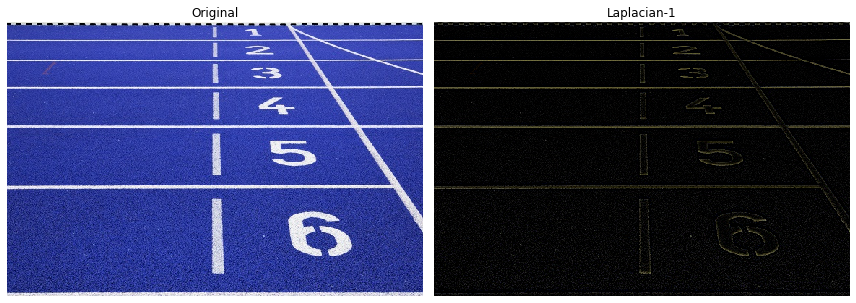

In [27]:
img = cv2.imread('athletic-field-1867053_1920.jpg')
GAD = cv2.pyrDown(img)
GAU = cv2.pyrUp(GAD)

temp = cv2.resize(GAU, (576, 379))
res = cv2.subtract(img, temp)

cv2.imshow('original', img)
cv2.imshow('GAD', GAD)
cv2.imshow('GAU', GAU)
cv2.imshow('temp', temp)
cv2.imshow('res', res)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(res)
plt.title('Laplacian-1')
plt.axis('off')

plt.tight_layout()
plt.show()

In [24]:
def laplacian_pyramid():
    img = cv2.imread('ryanair-5249631_1920.jpg')
    tmp = img.copy()
    
    img_down = []
    img_up = []
    img_shape = []
    
    win_titles = ['original', 'level1', 'level2', 'level3']
    img_down.append(tmp)
    img_shape.append(tmp.shape)
    
    for i in range(3):
        tmp = cv2.pyrDown(tmp)
        img_down.append(tmp)
        img_shape.append(tmp.shape)
        
    for i in range(3):
        tmp = img_down[i+1]
        tmp1 = cv2.pyrUp(tmp)
        tmp = cv2.resize(tmp1, dsize=(img_shape[i][1], img_shape[i][0]))
        img_up.append(tmp)
        
    for i in range(3):
        res = cv2.subtract(img_down[i], img_up[i])
        cv2.imshow(win_titles[i], res)
        print(res.shape)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [25]:
laplacian_pyramid()

(1277, 1920, 3)
(639, 960, 3)
(320, 480, 3)
